### To assess reliability under data incompleteness, MCAR missingness is injected on top of naturally occurring missing values and evaluated performance degradation across models

In [95]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
from tabicl import TabICLClassifier

In [67]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Running on CPU with more than 200 samples may be slow.*",
    category=UserWarning
)

In [148]:
data = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\datasets\Zero calcium score updated 26 Nov 2025.xlsx", na_values=["", " ", "NA", "N/A"])
data = data.replace(
    ["NA", "N/A", "na", "Na", "nan", "None", "NULL"],
    np.nan
)

#columns hidden on the excel sheet were said to be irrelvant so they were removed
dropcolumns = ["height","weight", "record","reason___3", "reason___4","reason___5","other_symptoms",
               "bp", "systolic_blood_pressure", "diastoic_blood_pressure","hr", "country","mother", 
               "father","language","glucose","random","lip_a_nmol_l", "lipoprotein_a_mg_dl", 
               "laboratory_data_complete","ct___1","ct___2", "contrast","contrast_amount", "radiation",
               "calcification_score","percentile_rank","plaque_burden","clinical_impression",
               "ct_coronary_angiography_complete", "Unnamed: 74", "Unnamed: 75", "Presence of any plaque (yes=1; no=0)",
                "CADrads_classification", "type", "ast" , "ethnicity", "calcium",
                 "type","potassium" ,   #removed since they have 15% missing values
                 "total_daily_dose_10","units_10","frequency_fibra","route_fibra",
                 "total_daily_dose_11","units_11","frequency_nico","route_nico",
               "name_of_drug_12","total_daily_dose_12", "units_12","frequency_cholest","route_chlo",
                 "name_of_drug_13","total_daily_dose_13","units_13","frequency_pcsk9",
                 "route_pcsk9","name_of_drug_14","total_daily_dose_14","units_14",
                 "frequency_rensins","route_rensie","name_of_drug_10", "drug_11", "name_of_statin",
                  "route_statin", "units_9", "frequency_statin", "pcsk9_inhibitors","resins"
                 ,"nicotinic_acid_group", "record.1", "coronary_calcification_score" ,"fibrates" ,"cholesterol_absorption", "ck"
                 # removed ck, fibrates, cholesterol_absorption due to high missingness
#  "coronary_calcification_score",,"nicotinic_acid_group", 
# , "pcsk9_inhibitors","resins", "statins", "total_daily_dose_9",
       
              ]
data = data.drop(columns=dropcolumns)
print(data.shape)
#print(data.head(50))

#Changing the coding for  calcium score if 0 then Y= 0 , if score > 0 then Y =1
data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"] = 1 - data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"].astype(int)
#print(data["Patients with ZERO CALCIUM SCORE (yes=1; no=0)"])

print(data.info())


(794, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 39 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   bmi_cal                                         779 non-null    float64
 1   age                                             794 non-null    int64  
 2   gender                                          794 non-null    int64  
 3   smoking                                         791 non-null    float64
 4   alcohol                                         785 non-null    float64
 5   hypertension                                    792 non-null    float64
 6   hyperlipidemia                                  784 non-null    float64
 7   diabetes                                        790 non-null    float64
 8   family                                          772 non-null    float64
 9   atherosclerosis                  

C:\Users\lavan\AppData\Local\Temp\ipykernel_37128\3648794906.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(


### Categorizarion of the variables -- Statin, fibrates, cholesterol absorption

In [136]:
statin_code_map = {
    1: "Atorvastatin",
    2: "Fluvastatin",
    3: "Lovastatin",
    4: "Pravastatin",
    5: "Rosuvastatin",
    6: "Simvastatin",
    7: "Pitavastatin",
    8: "None",
    9: "Not Recorded",
    10: "Other",
    11: "Unknown"
}


In [150]:
def get_statin_intensity(statin_type, dose_mg):
    if pd.isna(statin_type) or pd.isna(dose_mg):
        return "NaN"

    dose = float(dose_mg)

    # ----- Atorvastatin -----
    if statin_type == "Atorvastatin":
        if 10 <= dose <= 20: return "Medium"
        if 40 <= dose <= 80: return "High"
        return "NaN"

    # ----- Fluvastatin -----
    if statin_type == "Fluvastatin":
        if 20 <= dose <= 40: return "Low"
        if dose in [40, 80]: return "Medium"
        return "NaN"

    # ----- Lovastatin -----
    if statin_type == "Lovastatin":
        if dose == 20: return "Low"
        if 40 <= dose <= 80: return "Medium"
        return "NaN"

    # ----- Pitavastatin -----
    if statin_type == "Pitavastatin":
        if 1 <= dose <= 4: return "Medium"
        return "NaN"

    # ----- Pravastatin -----
    if statin_type == "Pravastatin":
        if 10 <= dose <= 20: return "Low"
        if 40 <= dose <= 80: return "Medium"
        return "NaN"

    # ----- Rosuvastatin -----
    if statin_type == "Rosuvastatin":
        if 5 <= dose <= 10: return "Medium"
        if 20 <= dose <= 40: return "High"
        return "NaN"

    # ----- Simvastatin -----
    if statin_type == "Simvastatin":
        if dose == 10: return "Low"
        if 20 <= dose <= 40: return "Medium"
        return "NaN"

    return "NaN"


In [151]:
data["statin_type"] = data["statins"].map(statin_code_map)

# Convert dose to numeric
data["statin_dose_mg"] = pd.to_numeric(data["total_daily_dose_9"], errors="coerce")

# Compute intensity
data["statin_intensity"] = data.apply(
    lambda r: get_statin_intensity(r["statin_type"], r["statin_dose_mg"]),
    axis=1
)
data = data.drop(columns= ["statins","statin_type","statin_dose_mg", "total_daily_dose_9" ] )

In [152]:
num_cols = ['bmi_cal', 'age', 'gender','alcohol', 'hypertension', 'hyperlipidemia',
            'diabetes', 'family', 'atherosclerosis', 'pad', 'cad', 'stroke', 'troponin', 'ck', 'hb', 
'wbc', 'plt', 'tc', 'tg', 'hdl', 'ldl', 'hba1c', 'crp', 'egfr', 'creatinine', 'bun', 'sodium', 
'lipoprotein_a', 'apoa', 'apob', 'ratio', 'bilirubin', 'alt', 'ggt', 'chloride', 'adjusted_calcium'] 
 # numeric 
cat_cols = [ 'smoking','statin_intensity']#, 'fibrates', 'cholesterol_absorption']  #cat


#print(len(num_cols))

In [153]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = data.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))


### Defining X and Y

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

df = data.copy()

TARGET = "Patients with ZERO CALCIUM SCORE (yes=1; no=0)"  
y = df[TARGET]
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=[np.number]).columns

In [155]:
df.isna().sum()


bmi_cal                                           15
age                                                0
gender                                             0
smoking                                            0
alcohol                                            9
hypertension                                       2
hyperlipidemia                                    10
diabetes                                           4
family                                            22
atherosclerosis                                   13
pad                                               31
cad                                               32
stroke                                            75
troponin                                          41
hb                                                17
wbc                                               17
plt                                               18
tc                                                23
tg                                            

#### Cross-Validation Setup

In [157]:
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)



#### Missingness run

In [158]:
def inject_mcar_missingness_numeric(X, num_cols, additional_frac, random_state):
    rng = np.random.default_rng(random_state)
    X_miss = X.copy(deep=True)

    col_idx = [X_miss.columns.get_loc(c) for c in num_cols]

    observed_mask = ~X_miss.iloc[:, col_idx].isna().values
    n_observed = observed_mask.sum()

    n_to_mask = int(additional_frac * n_observed)
    if n_to_mask == 0:
        return X_miss

    observed_indices = np.argwhere(observed_mask)
    selected = rng.choice(len(observed_indices), size=n_to_mask, replace=False)

    rows = observed_indices[selected][:, 0]
    cols = [col_idx[i] for i in observed_indices[selected][:, 1]]

    X_miss.iloc[rows, cols] = np.nan
    return X_miss



In [159]:
xgb_model = Pipeline([
    #("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


In [160]:
tabpfn_model = TabPFNClassifier(device="cpu")
tabicl_model = TabICLClassifier()


In [161]:
def evaluate_single_split(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    return {
        "auc": roc_auc_score(y_test, probs),
        "prauc": average_precision_score(y_test, probs)
    }


#### Insert missingness in data

In [177]:
missingness_levels = {
    "+0%": 0.00 ,
    "+5%": 0.05 ,
    "+10%": 0.10 ,
    "+15%": 0.15 ,
    
}


In [178]:
results = []

for i, (label, frac) in enumerate(missingness_levels.items()):

    seed = 1000 + i * 100

    Xtr = inject_mcar_missingness_numeric(
        X_train_base, num_cols, frac, random_state=seed
    )
    Xte = inject_mcar_missingness_numeric(
        X_test_base, num_cols, frac, random_state=seed + 100
    )

    # XGBoost
    res_xgb = evaluate_single_split(
        xgb_model, Xtr, y_train, Xte, y_test
    )
    res_xgb.update({"model": "XGBoost", "missingness": label})
    results.append(res_xgb)

    # TabPFN
    res_tabpfn = evaluate_single_split(
        tabpfn_model, Xtr, y_train, Xte, y_test
    )
    res_tabpfn.update({"model": "TabPFN", "missingness": label})
    results.append(res_tabpfn)

    # TabICL
    res_tabicl = evaluate_single_split(
        tabicl_model, Xtr, y_train, Xte, y_test
    )
    res_tabicl.update({"model": "TabICL", "missingness": label})
    results.append(res_tabicl)


In [179]:
results_df = pd.DataFrame(results)


print("\nMissingness Robustness Results:\n")
print(results_df.to_string(index=False))



Missingness Robustness Results:

     auc    prauc   model missingness
0.729661 0.724170 XGBoost         +0%
0.742007 0.768928  TabPFN         +0%
0.731877 0.761202  TabICL         +0%
0.603830 0.576796 XGBoost         +5%
0.613169 0.592306  TabPFN         +5%
0.594729 0.581516  TabICL         +5%
0.487496 0.503261 XGBoost        +10%
0.463992 0.491281  TabPFN        +10%
0.482035 0.491909  TabICL        +10%
0.500000 0.509434 XGBoost        +15%
0.540361 0.527838  TabPFN        +15%
0.543289 0.545944  TabICL        +15%


In [182]:
# baseline AUC per model
baseline = (
    results_df[results_df["missingness"] == "+0%"]
    .set_index("model")["auc"]
)

# add relative degradation
results_df["auc_drop"] = results_df.apply(
    lambda r: baseline[r["model"]] - r["auc"],
    axis=1
)

results_df["auc_drop_pct"] = (
    results_df["auc_drop"] / baseline[results_df["model"]].values
) * 100

results_df


,auc,prauc,model,missingness,missingness_pct,auc_drop,auc_drop_pct
0,0.729661,0.724170,XGBoost,+0%,0,0.000000,0.000000
1,0.742007,0.768928,TabPFN,+0%,0,0.000000,0.000000
2,0.731877,0.761202,TabICL,+0%,0,0.000000,0.000000
3,0.603830,0.576796,XGBoost,+5%,5,0.125831,17.245119
4,0.613169,0.592306,TabPFN,+5%,5,0.128838,17.363481
5,0.594729,0.581516,TabICL,+5%,5,0.137148,18.739187
6,0.487496,0.503261,XGBoost,+10%,10,0.242165,33.188720
7,0.463992,0.491281,TabPFN,+10%,10,0.278015,37.468003
8,0.482035,0.491909,TabICL,+10%,10,0.249842,34.137111
9,0.500000,0.509434,XGBoost,+15%,15,0.229661,31.475054


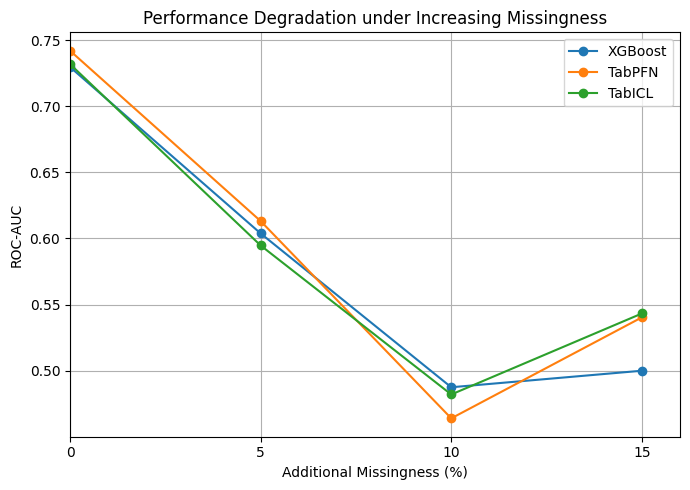

In [187]:
import matplotlib.pyplot as plt

# convert missingness labels to numeric %
results_df["missingness_pct"] = (
    results_df["missingness"]
    .str.replace("%", "", regex=False)
    .str.replace("+", "", regex=False)
    .astype(int)
)

plt.figure(figsize=(7, 5))

for model in results_df["model"].unique():
    df_m = (
        results_df[results_df["model"] == model]
        .sort_values("missingness_pct")
    )
    plt.plot(
        df_m["missingness_pct"],
        df_m["auc"],
        marker="o",
        label=model
    )

plt.xlabel("Additional Missingness (%)")
plt.ylabel("ROC-AUC")
plt.title("Performance Degradation under Increasing Missingness")
plt.legend()
plt.grid(True)
plt.xticks([0, 5, 10, 15])
plt.xlim(0, 16)

plt.tight_layout()
plt.show()






#### Foundation models are not better at baseline, but are more resilient when missingness is high.